In [1]:
from skimage.feature import hog
from skimage import io
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

from skimage import exposure


In [2]:
# Define the root directory where your "images" folder is located
root_directory = "dtd-r1.0.1/dtd/images"

# Create a list of all image file extensions you want to consider (e.g., '.jpg', '.png')
image_extensions = ['.jpg', '.png', '.jpeg']

In [3]:
HOG_features = []

In [4]:
def extract_and_limit_hog_features(image, limit):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    fd, hog_image = hog(gray_image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    
    # Limit the number of features to the desired value
    fd = fd[:limit]
    
    return fd

In [5]:
limit_per_image = 256  

for folder_name, subfolders, filenames in os.walk(root_directory):
    for filename in filenames:
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
            image_path = os.path.join(folder_name, filename)
            image = cv2.imread(image_path)
            hog_features = extract_and_limit_hog_features(image, limit_per_image)
            HOG_features.append((filename, hog_features))

In [6]:
import csv
# Define the CSV file path to save the data.
csv_file_path = "HOG_features.csv"

# Save the image name and vector data to a CSV file.
with open(csv_file_path, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['ImageName', 'Vector'])  # Write header row

    for image_name, vector in HOG_features:
        csv_writer.writerow([image_name, ','.join(map(str, vector))])

In [7]:
def euclidean(a, b):
    return np.linalg.norm(a - b)
def cosine(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [8]:
import csv
import numpy as np
def calculate_distances(image_name1, image_name2, csv_file_path="HOG_features.csv"):
    vector1 = None
    vector2 = None
    
    # Read the CSV file to get the vectors for the given image names.
    with open(csv_file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        next(csv_reader)  # Skip the header row
        for row in csv_reader:
            if row[0] == image_name1:
                vector1 = np.array(list(map(float, row[1].split(','))))
            if row[0] == image_name2:
                vector2 = np.array(list(map(float, row[1].split(','))))

    if vector1 is None or vector2 is None:
        print("One or both of the images were not found in the CSV file.")
        return

    # Calculate Euclidean distance and cosine similarity between the vectors.
    euclidean_distance = euclidean(vector1, vector2)
    cosine_similarity = cosine(vector1, vector2)

    return euclidean_distance, cosine_similarity


val = calculate_distances("banded_0002.jpg","banded_0004.jpg")

print("euclidean Distance:",val[0])
print("Cosine Similarity :",val[1])

euclidean Distance: 2.3246063080821777
Cosine Similarity : 0.5428065544653734


In [9]:
# Define a function to search for the most similar images using HOG features.
def search(query_image_path, csv_file_path, top_k=5):
    # Open the query image using PIL.
    query_image = Image.open(query_image_path)
    query_image_array = np.array(query_image)

    # Calculate HOG features for the query image.
    query_hog_features = extract_and_limit_hog_features(query_image_array, 256)

    # Read the CSV file to get image vectors.
    image_data_list = []
    with open(csv_file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        next(csv_reader)  # Skip the header row
        for row in csv_reader:
            image_name = row[0]
            vector = np.array(list(map(float, row[1].split(','))))
            image_data_list.append((image_name, vector))

    # Calculate cosine and Euclidean distances between the query HOG vector and all other vectors.
    cosine_similarities = []
    euclidean_distances = []
    for image_name, vector in image_data_list:
        cosine_similarity = cosine(query_hog_features, vector)  # Cosine similarity ranges from -1 to 1, so convert it to a similarity score.
        euclidean_distance = euclidean(query_hog_features, vector)
        cosine_similarities.append((image_name, cosine_similarity))
        euclidean_distances.append((image_name, euclidean_distance))

    # Sort the images by similarity/distance in descending order.
    top_cosine_similar_images = sorted(cosine_similarities, key=lambda x: x[1], reverse=True)[:top_k]
    top_euclidean_similar_images = sorted(euclidean_distances, key=lambda x: x[1])[:top_k]

    return top_cosine_similar_images, top_euclidean_similar_images, query_hog_features

In [10]:
def extract_and_limit_hog_features(image, limit):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    fd, hog_image = hog(gray_image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    
    # Limit the number of features to the desired value
    fd = fd[:limit]
    
    return fd

In [20]:
from PIL import Image
import cv2
from skimage.feature import hog
query_image_path = "thumb_nov22_03.jpg"
cosine_results, euclidean_results,query_vector  = search(query_image_path, 'HOG_features.csv', top_k=5)

#Print the vector of the query image, and the top-k similar images along with their similarity/distance scores.
#print("Query Image Vector:", query_vector)
print("\nTop 5 Cosine Similar Images:")
for i, (image_name, similarity) in enumerate(cosine_results, 1):
    print(f"Top {i}: {image_name} (Similarity: {similarity:.4f})")

print("\nTop 5 Euclidean Distance Images:")
for i, (image_name, distance) in enumerate(euclidean_results, 1):
    print(f"Top {i}: {image_name} (Euclidean Distance: {distance:.4f})")





Top 5 Cosine Similar Images:
Top 1: banded_0010.jpg (Similarity: nan)
Top 2: crosshatched_0137.jpg (Similarity: 0.8982)
Top 3: crosshatched_0160.jpg (Similarity: 0.8885)
Top 4: pitted_0031.jpg (Similarity: 0.8824)
Top 5: perforated_0043.jpg (Similarity: 0.8811)

Top 5 Euclidean Distance Images:
Top 1: crosshatched_0137.jpg (Euclidean Distance: 1.2082)
Top 2: crosshatched_0116.jpg (Euclidean Distance: 1.2226)
Top 3: bumpy_0150.jpg (Euclidean Distance: 1.2378)
Top 4: smeared_0134.jpg (Euclidean Distance: 1.2423)
Top 5: knitted_0073.jpg (Euclidean Distance: 1.2453)


C:\Users\yamrs\AppData\Local\Temp\ipykernel_23640\1163413707.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


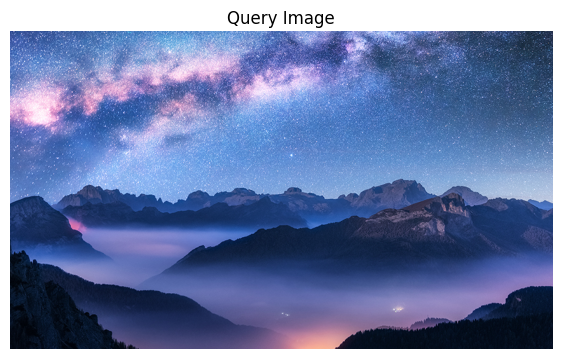

In [21]:
import matplotlib.pyplot as plt
from PIL import Image

# Load the query image using PIL.
query_image = Image.open(query_image_path)
query_image_array = np.array(query_image)

# Visualize the query image
plt.figure(figsize=(7, 7))
plt.imshow(query_image_array)
plt.title('Query Image')
plt.axis('off')
plt.show()


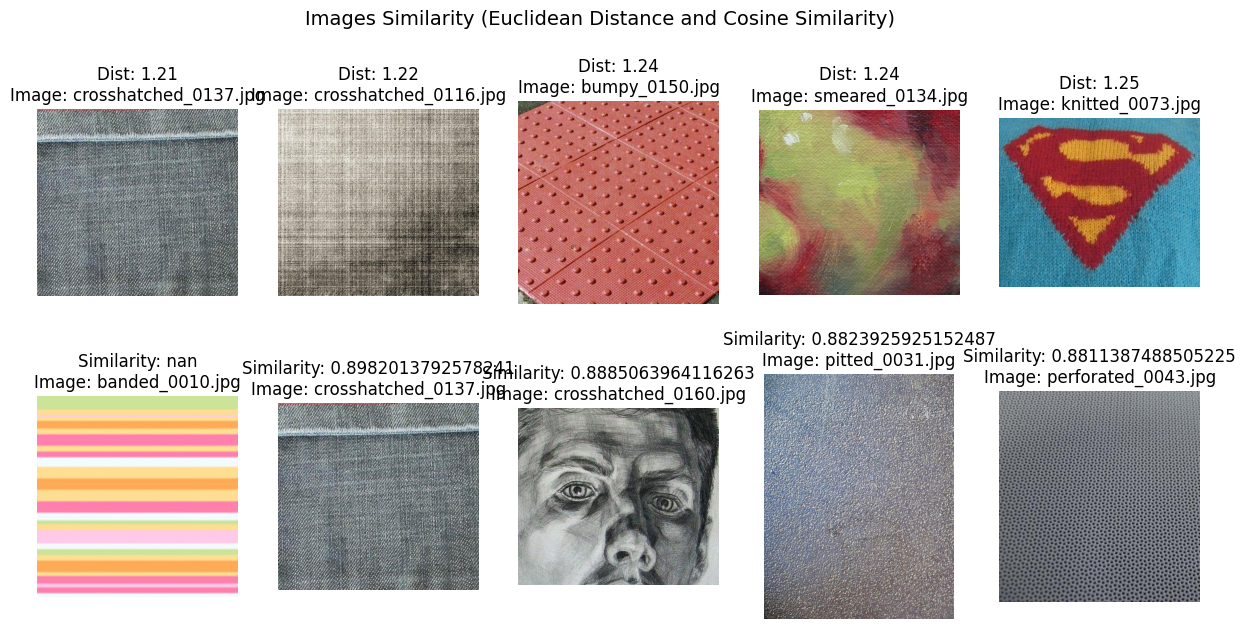

In [22]:
import re

from PIL import Image

top_k = 5

# Regular expression pattern to remove numbers, "jpg", and underscores
pattern = r'\d+|\.jpg|_'

fig, axes = plt.subplots(2, top_k, figsize=(15, 7))
fig.suptitle('Images Similarity (Euclidean Distance and Cosine Similarity)', fontsize=14)

# Plot the closest images based on Euclidean distance.
for i, (image_name, distance) in enumerate(euclidean_results[:top_k]):
    # Clean the image_name to remove numbers, "jpg," and underscores
    cleaned_file_path = re.sub(pattern, '', image_name)

    # Construct the full path to the image
    image_path = f'dtd-r1.0.1/dtd/images/{cleaned_file_path}/{image_name}'

    # Open and plot the image
    image = Image.open(image_path)
    axes[0, i].imshow(image)
    axes[0, i].set_title(f'Dist: {distance:.2f}\nImage: {image_name}')
    axes[0, i].axis('off')

# Plot the closest images based on Cosine similarity.
for i, (image_name, similarity) in enumerate(cosine_results[:top_k]):
    # Clean the image_name to remove numbers, "jpg," and underscores
    cleaned_file_path = re.sub(pattern, '', image_name)

    # Construct the full path to the image
    image_path = f'dtd-r1.0.1/dtd/images/{cleaned_file_path}/{image_name}'

    # Open and plot the image
    image = Image.open(image_path)
    axes[1, i].imshow(image)
    axes[1, i].set_title(f'Similarity: {similarity:}\nImage: {image_name}')
    axes[1, i].axis('off')

plt.show()


In [19]:
import csv
import time
import re

import csv
import time
import re

pattern = r'\d+|\.jpg|_'

def calculate_precision_at_k(true_image, top_k_results):
    pattern = r'\d+|\.jpg|_'
    total = 0

    for result in top_k_results:
        filename, _ = result
        filename = re.sub(pattern, '', filename)
        if filename == true_image:
            print("true")
            # print(true_image)
            # print(filename)
            total += 1
            
            
        else:
            print("false")
            # print(true_image)
            # print(filename)
        
        return total
    

def calculate_precision_at_1(true_image, top_k_results):
    pattern = r'\d+|\.jpg|_'

    if top_k_results:
        filename, _ = top_k_results[0]
        filename = re.sub(pattern, '', filename)
        if filename == true_image:
            return 1.0
        else:
            return 0.0



    

def calculate_average_precision_at_k(csv_file_path, top_k):
    with open(csv_file_path, 'r') as csvfile:
        csv_reader = csv.reader(csvfile)
        next(csv_reader)  # Skip the header row
        total_precision_at_k = 0
        total_retrieval_time = 0
        total_precision_at_1 = 0
        total_images = 0
        top_k = 10

        for row in csv_reader:
            image_name, _ = row[0], row[1]
            cleaned_file_path = re.sub(pattern, '', image_name)
            print(image_name)
            image_path = f'dtd-r1.0.1/dtd/images/{cleaned_file_path}/{image_name}'
            query_image_path = image_path
            #print(query_image_path)
            start_time = time.time()
            top_cosine_similar_images, _, _ = search(query_image_path, csv_file_path, top_k)
            retrieval_time = time.time() - start_time
            precision_at_k = calculate_precision_at_k(cleaned_file_path, top_cosine_similar_images)
            precision_at_1 = calculate_precision_at_1(cleaned_file_path, top_cosine_similar_images)

            total_precision_at_k += precision_at_k
            total_retrieval_time += retrieval_time
            total_precision_at_1 += precision_at_1
            total_images += 1

    average_precision_at_k = total_precision_at_k / total_images
    average_retrieval_time = total_retrieval_time / total_images
    print("total_images: ", total_images)
    print("total_precision_at_k: ", total_precision_at_k)
    print("total_retrieval_time: ",total_retrieval_time)

    return average_precision_at_k, average_retrieval_time, total_precision_at_1

csv_file_path = 'HOG_features.csv'
top_k = 10  # You can change this value as needed

average_precision_at_10, average_retrieval_time, total_precision_at_1 = calculate_average_precision_at_k(csv_file_path, top_k)

print(f'Average Precision at {top_k}: {average_precision_at_10}')
print(f'Average Retrieval Time: {average_retrieval_time} seconds')
print(f'Average Precision at 1: {total_precision_at_1}')


banded_0002.jpg


C:\Users\yamrs\AppData\Local\Temp\ipykernel_23640\1163413707.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


true
banded_0004.jpg
true
banded_0005.jpg
true
banded_0006.jpg
true
banded_0008.jpg
true
banded_0009.jpg
true
banded_0010.jpg
true
banded_0011.jpg
true
banded_0012.jpg
true
banded_0013.jpg
true
banded_0016.jpg
true
banded_0019.jpg
true
banded_0021.jpg
true
banded_0022.jpg
true
banded_0023.jpg
true
banded_0024.jpg
true
banded_0025.jpg
true
banded_0030.jpg
true
banded_0033.jpg
true
banded_0034.jpg
true
banded_0036.jpg
true
banded_0037.jpg
false
banded_0039.jpg
true
banded_0041.jpg
true
banded_0042.jpg
true
banded_0043.jpg
true
banded_0044.jpg
true
banded_0045.jpg
true
banded_0046.jpg
true
banded_0047.jpg
true
banded_0049.jpg
false
banded_0051.jpg
true
banded_0053.jpg
true
banded_0055.jpg
true
banded_0057.jpg
false
banded_0058.jpg
true
banded_0059.jpg
true
banded_0060.jpg
true
banded_0061.jpg
true
banded_0062.jpg
true
banded_0063.jpg
true
banded_0064.jpg
true
banded_0066.jpg
true
banded_0067.jpg
true
banded_0068.jpg
true
banded_0069.jpg
true
banded_0072.jpg
true
banded_0073.jpg
true
bande

In [23]:
import csv
import time
import re
import numpy as np
import matplotlib.pyplot as plt

# Define the pattern and functions for precision calculation as shown in your code

def calculate_precision_recall_curve(csv_file_path, thresholds, precisions, recalls):
    for threshold in thresholds:
        with open(csv_file_path, 'r') as csvfile:
            csv_reader = csv.reader(csvfile)
            next(csv_reader)  # Skip the header row
            total_precision_at_k = 0
            total_images = 0

            for row in csv_reader:
                image_name, _ = row[0], row[1]
                cleaned_file_path = re.sub(pattern, '', image_name)
                image_path = f'dtd-r1.0.1/dtd/images/{cleaned_file_path}/{image_name}'
                query_image_path = image_path
                top_cosine_similar_images, _, _ = search(query_image_path, csv_file_path, top_k)
                precision_at_k = calculate_precision_at_k(cleaned_file_path, top_cosine_similar_images)
                total_precision_at_k += precision_at_k
                total_images += 1

        average_precision_at_k = total_precision_at_k / total_images
        precisions.append(average_precision_at_k)
        recalls.append(total_images)

    return precisions, recalls

# Function to plot the Precision-Recall curve
def plot_precision_recall_curve(precisions, recalls):
    plt.plot(recalls, precisions, marker='.')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid()
    plt.show()

# Define your CSV file path, thresholds, precisions, and recalls
csv_file_path = 'HOG_features.csv'
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]  # Define the thresholds you want to use
precisions = []
recalls = []

precisions, recalls = calculate_precision_recall_curve(csv_file_path, thresholds, precisions, recalls)
plot_precision_recall_curve(precisions, recalls)


C:\Users\yamrs\AppData\Local\Temp\ipykernel_23640\1163413707.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
false
true
true
true
true
true
true
true
true
false
true
true
true
false
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
false
true
true
false
false
true
true
false
false
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
false
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
false
true
true
true
false
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
true
false
false
false
false
false
false
false
false
true
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
f

KeyboardInterrupt: 